## [`Cell`](../../../single_cell_parser/cell.py) and NEURON API

We can run simulations with [`Cell`](../../../single_cell_parser/cell.py) using NEURON's Python API, as outlined below

In [ ]:
import Interface as I
from getting_started import example_data_dir

cell_param_file = I.os.path.join(
    example_data_dir,
    'biophysical_constraints',
    '86_CDK_20041214_BAC_run5_soma_Hay2013_C2center_apic_rec.param')

{'info': {'name': 'hay_2011_dend_test',
          'author': 'regger',
          'date': '15Oct2014'},
 'NMODL_mechanisms': {'channels': '/'},
 'mech_globals': {},
 'neuron': {'filename': '/gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/getting_started/example_data/anatomical_constraints/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc',
            'Soma': {'properties': {'Ra': 100.0,
                                    'cm': 1.0,
                                    'ions': {'ek': -85.0, 'ena': 50.0}},
                     'mechanisms': {'global': {},
                                    'range': {'pas': {'spatial': 'uniform',
                                                      'g': 3.26e-05,
                                                      'e': -90},
                                              'Ca_LVAst': {'spatial': 'uniform',
                                                           'gCa_LVAstbar': 0.00462},
                      

In [ ]:
from single_cell_parser.cell_modify_functions.scale_apical_morph_86 import scale_apical_morph_86
import neuron
h = neuron.h
I.logger.setLevel("DEBUG")

cell_param = I.scp.build_parameters(cell_param_file) # this is the main method to load in parameterfiles
cell = I.scp.create_cell(
    cell_param.neuron, 
    scaleFunc=scale_apical_morph_86
    ) # this is the main method to create a cell

[WARNING] __init__.py: Keyword scaleFunc is deprecated! New: To ensure reproducability, scaleFunc should be specified in the parameters, as described in single_cell_parser.cell_modify_funs
[INFO] single_cell_parser: -------------------------------
[INFO] single_cell_parser: Starting setup of cell model...
[INFO] single_cell_parser: Loading cell morphology...
[INFO] reader: Reading hoc file /gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/getting_started/example_data/anatomical_constraints/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc
[INFO] cell_parser: Creating AIS:
[INFO] cell_parser:     axon hillock diameter: 3.00
[INFO] cell_parser:     initial segment diameter: 1.75
[INFO] cell_parser:     myelin diameter: 1.00
[WARNING] cell_parser.py: Keyword scaleFunc is deprecated! New: To ensure reproducability, scaleFunc should be specified in the parameters, as described in single_cell_parser.cell_modify_funs
[INFO] scale_apical_morph_86: Scale

### Current injection at the soma

In [ ]:
import neuron
h = neuron.h

In [ ]:
iclamp = h.IClamp(0.5, sec=cell.soma)
iclamp.delay = 150 # [ms] give the cell time to reach steady state
iclamp.dur = 5 # [ms] rectangular pulse
iclamp.amp = 1.9 # [nA]
%time I.scp.init_neuron_run(cell_param.sim, vardt=True) # run the simulation 

CPU times: user 741 ms, sys: 8.93 ms, total: 750 ms
Wall time: 836 ms


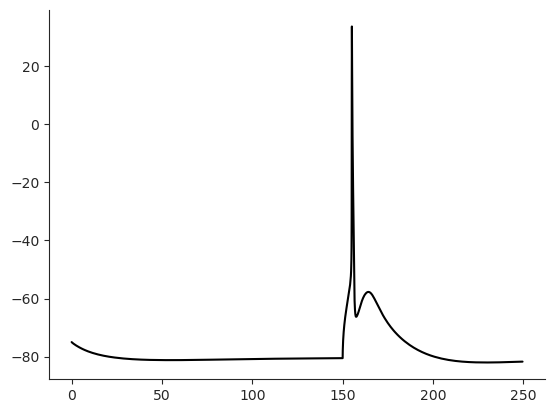

In [ ]:
%matplotlib inline
I.sns.set_style('ticks')
I.plt.plot(cell.tVec, cell.soma.recVList[0], c = 'k');
I.sns.despine()

### Step currents at the soma

How does the cell respond to different amplitudes of the step current?

In [ ]:
cell_param.sim.tStop = 3000
iclamp.dur = 2000
iclamp.delay = 500
simresult = {}
for amp in [0.619, 0.793, 1.507]:
    iclamp.amp = amp
    I.scp.init_neuron_run(cell_param.sim, vardt=True)
    simresult[amp] = I.np.array(cell.tVec), I.np.array(cell.soma.recVList[0])

[WARNING] client: Connection dropped: socket connection broken
[WARNING] client: Transition to CONNECTING
[WARNING] client: Session has expired
[WARNING] client: Connection dropped: socket connection broken
[WARNING] client: Transition to CONNECTING
[WARNING] client: Session has expired
[WARNING] client: Connection dropped: socket connection broken
[WARNING] client: Transition to CONNECTING
[WARNING] client: Session has expired
[WARNING] client: Connection dropped: socket connection broken
[WARNING] client: Transition to CONNECTING
[WARNING] client: Session has expired


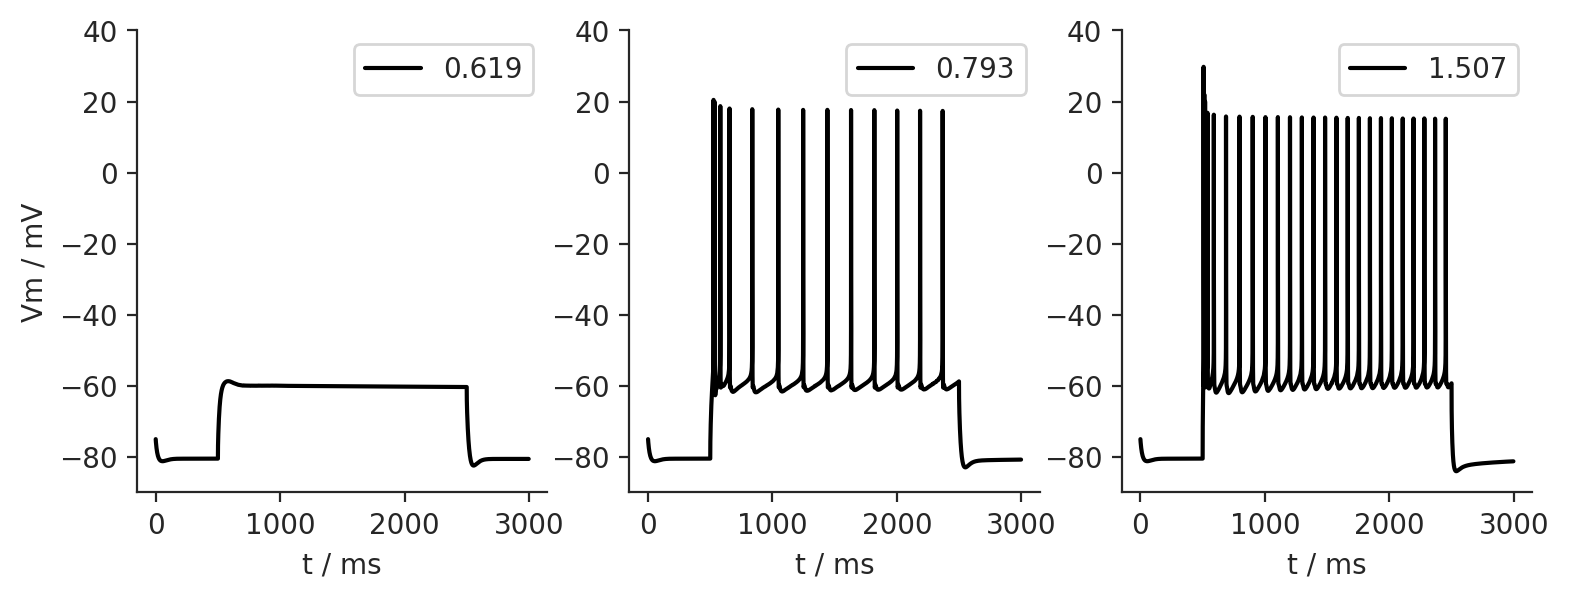

In [ ]:
fig = I.plt.figure(figsize = (9,3), dpi = 200)
for lv, k in enumerate(sorted(simresult.keys())):
    ax = fig.add_subplot(1,3,lv+1)
    ax.plot(*simresult[k], label = k, c = 'k');
    ax.legend(loc = 'upper right')
    ax.set_ylim([-90, 40])
    ax.set_xlabel('t / ms')
    if lv == 0:
        ax.set_ylabel('Vm / mV')
I.sns.despine()

### Pair injection at the soma and apical dendrite

Now let's place a pipette on the apical trunk at a soma distance of 620 microns and inject current synchronously at this position and at the soma. For the current at the soma, we choose a rectangular pulse again. The current at the apical injection site should resemble the shape of a evoked post synaptic potential (epsp). Have a look at the folder mechanisms/synapses to see how epsp is implemented in hoc code.

In [ ]:
# map between sections and somadistance
sec_dist_dict = {cell.distance_to_soma(sec, 1.0): sec for sec in cell.sections}

def get_section_at_distance(cell, dist):
    dummy = {k - dist: v for k,v in sec_dist_dict.items() if k > dist}
    closest_sec = dummy[min(dummy)]
    x = (dist - cell.distance_to_soma(closest_sec, 0.0)) / closest_sec.L
    return x, closest_sec

In [ ]:
cell_param.sim.tStop = 500
x, sec = get_section_at_distance(cell, 620)

iclamp = h.IClamp(0.5, sec=cell.soma)
iclamp.delay = 295 # give the cell time to reach steady state
iclamp.dur = 5 # 5ms rectangular pulse
iclamp.amp = 1.9 # 1.9 ?? todo ampere

iclamp2 = h.epsp(x, sec=sec)
iclamp2.onset = 300
iclamp2.imax = 0.5
iclamp2.tau0 = 1.0 # rise time constant
iclamp2.tau1 = 5 # decay time constant
cell.iclamp2 = iclamp2

%time I.scp.init_neuron_run(cell_param.sim, vardt=True) # run the simulation 

CPU times: user 1.43 s, sys: 5.9 ms, total: 1.44 s
Wall time: 1.43 s


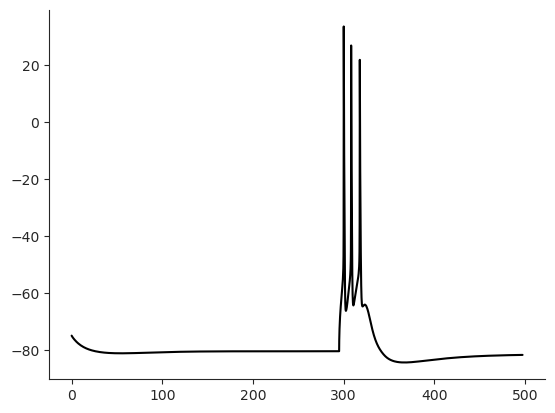

In [ ]:
I.plt.plot(cell.tVec, cell.soma.recVList[0], c = 'k');
I.sns.despine()